## Image Classfiication with CIFAR1O Dataset 

### Import Libraries

In [1]:
# Installing other Libraries 
import os
import time 
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Test Pytorch Installation 
x = torch.rand(3, 3)
print(x)

tensor([[0.4267, 0.6767, 0.2754],
        [0.8536, 0.9746, 0.9044],
        [0.5725, 0.6080, 0.7403]])


In [3]:
import pickle

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Load Meta data

In [4]:
batches_meta = 'cifar-10-batches-py/batches.meta'

In [5]:
# Get Meta Data
meta_data = unpickle(batches_meta)

### Load test batch

In [6]:
test_batch = 'cifar-10-batches-py/test_batch'
test_batch: dict = unpickle(test_batch)

In [14]:
# Add this line to define label_names
label_names = meta_data[b'label_names']

### Build Model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F  # Import the functional API

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [9]:
model = CNNModel()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss combines softmax and cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

### Get Model Summary

In [10]:
from torchsummary import summary

In [11]:
# Get Model Summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Linear-10                 [-1, 1024]       4,195,328
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 512]         524,800
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [ ]:
# incase

### Prepare Test Data

In [12]:
### Get Test Data
test_images = test_batch[b'data']
test_labels = test_batch[b'labels']

In [13]:
# Reshape the test images for image visualization
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

### Plot Test Images

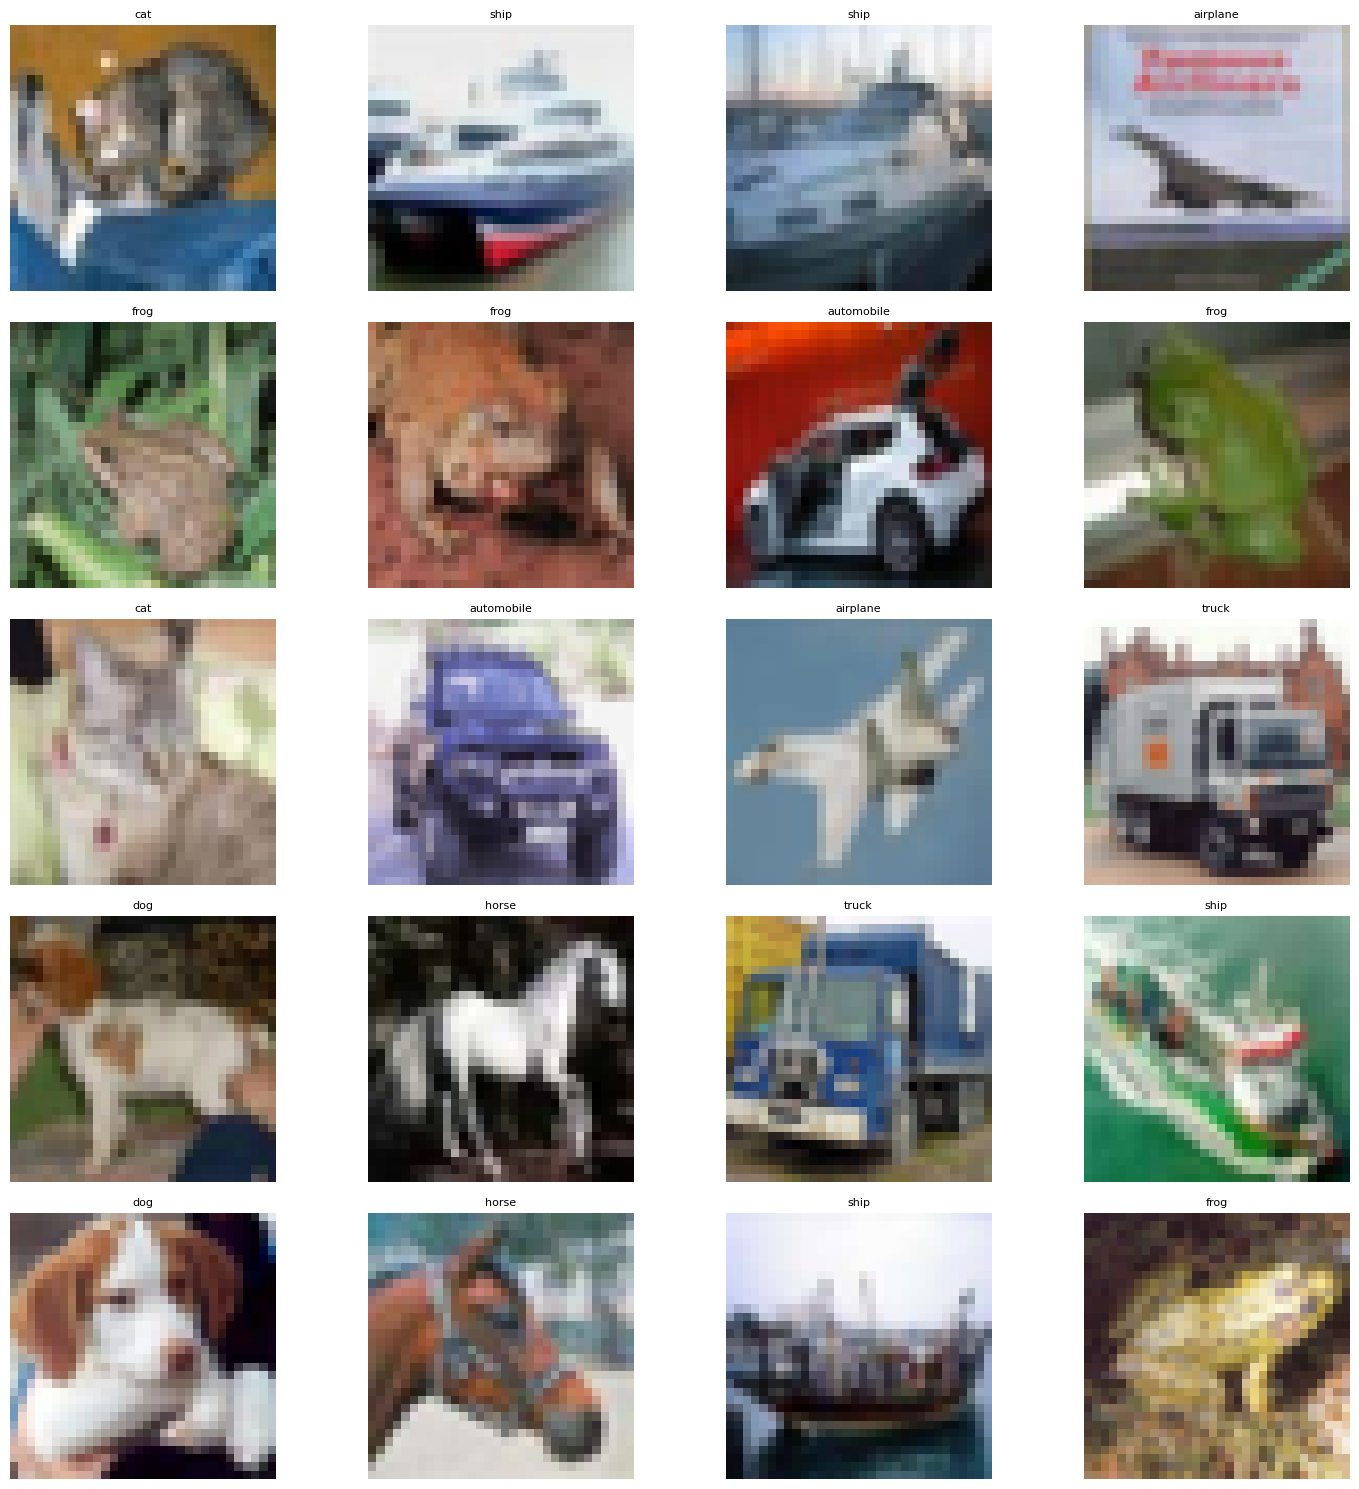

In [18]:
# Number of images to display
num_images = 20
num_cols = 4  # 10 images per row
num_rows = num_images // num_cols  # Number of rows

# Set up the plot grid
plt.figure(figsize=(15, 15))  # Adjust figure size for better visibility

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[test_labels[i]].decode('utf-8'), fontsize=8)  # Decode label to string
    plt.axis('off')  # Hide axis

# Display the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

### Run Model prediction

In [19]:
# Load the saved model
model = CNNModel()  # Create an instance of the model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Move the model to the same device you used for training
model.eval()  # Set the model to evaluation mode

/var/folders/4v/bxfts39910v7lnlbgx6zn33m0000gp/T/ipykernel_30385/2232258018.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [20]:
# Normalize test images
test_images_normalized = test_images.astype('float32') / 255.0

# Create test tensor
test_images_tensor = torch.tensor(test_images_normalized).permute(0, 3, 1, 2)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Move to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_images_tensor = test_images_tensor.to(device)

In [21]:
# Make predictions
with torch.no_grad():
    outputs = model(test_images_tensor)
    _, predicted = torch.max(outputs, 1)

# Move predictions to CPU and convert to numpy for comparison
predicted = predicted.cpu().numpy()

# Calculate accuracy
correct = (predicted == test_labels).sum()
total = len(test_labels)
accuracy = 100 * correct / total

print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 82.24%


In [22]:
type(predicted)

numpy.ndarray

### Plot Predictions

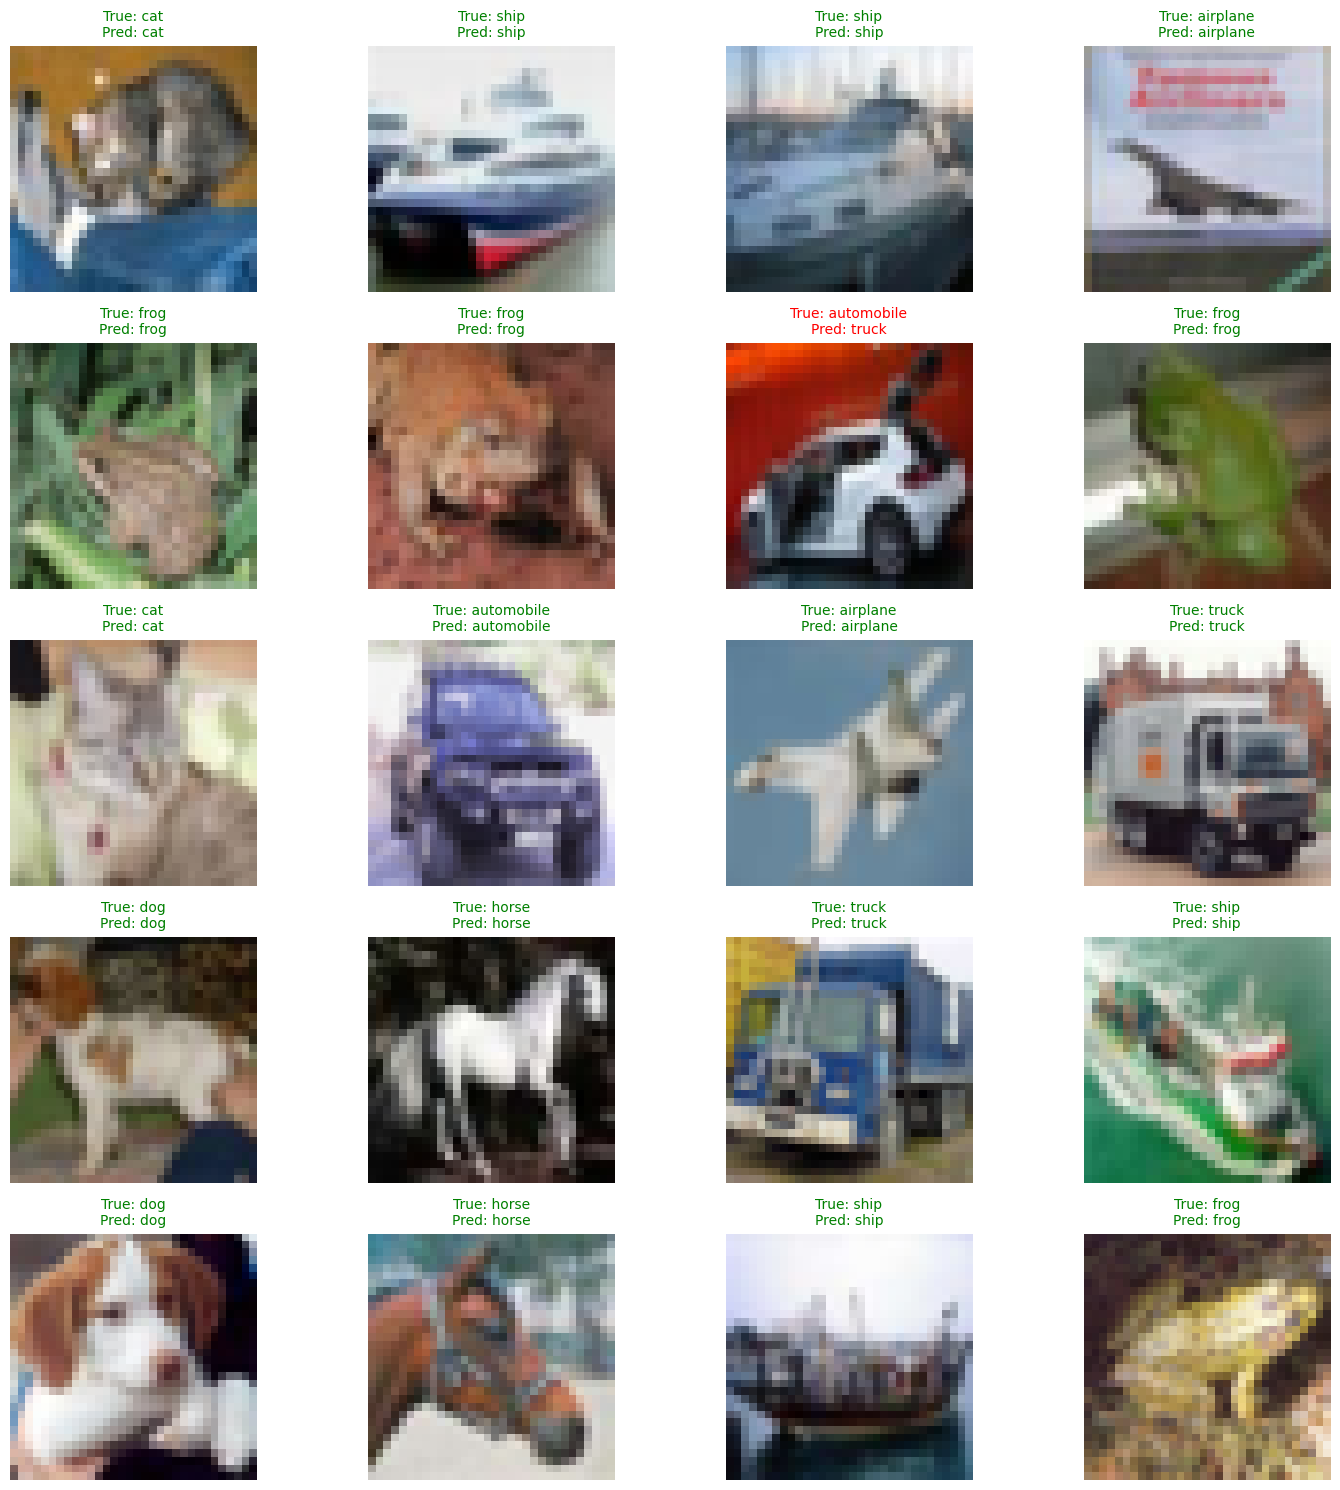

In [23]:
# Number of images to display
num_images = 20
num_cols = 4  # 5 images per row
num_rows = num_images // num_cols

# Set up the plot grid
plt.figure(figsize=(15, 15))  # Adjust figure size for better visibility

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    true_label = label_names[test_labels[i]].decode('utf-8')
    pred_label = label_names[predicted[i]].decode('utf-8')
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.axis('off')  # Hide axis

# Display the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()